<a href="https://colab.research.google.com/github/nshah-waripari/deep_learning/blob/main/siamese_signature_trax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trax
# !pip install -q -U git+https://github.com/google/trax@master


     |████████████████████████████████| 624kB 11.6MB/s 
     |████████████████████████████████| 153kB 28.0MB/s 
     |████████████████████████████████| 3.4MB 36.0MB/s 
     |████████████████████████████████| 2.3MB 28.0MB/s 
     |████████████████████████████████| 1.2MB 34.6MB/s 
     |████████████████████████████████| 3.9MB 32.1MB/s 
     |████████████████████████████████| 256kB 41.2MB/s 
     |████████████████████████████████| 368kB 35.2MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 901kB 29.6MB/s 
     |████████████████████████████████| 3.3MB 30.8MB/s 


In [ ]:
# library imports
import os
import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
import random as rnd


# set random seeds
#trax.supervised.trainer_lib.init_random_number_generators(34)
rnd.seed(34)

**Step 1: Data Loading and Exploration**

In [ ]:
# # mount the google drive to point the data folder
from google.colab import drive
import pandas as pd
drive.mount('/gdrive')
train_df = pd.read_csv('/gdrive/My Drive/siamese_signature/data/train_data.csv', names=['left', 'right', 'dup'])
test_df = pd.read_csv('/gdrive/My Drive/siamese_signature/data/test_data.csv', names=['left', 'right', 'dup'])


KeyboardInterrupt: ignored

In [ ]:
train_df.head()

,left,right,dup
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [ ]:
test_df.head()

,left,right,dup
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [ ]:
# display images
import matplotlib.pyplot as plt
#import matplotlib.pyplot.tight_layout
%matplotlib inline
#pip3 install pillow
import sys
#from IPython.display import display, Image 
from PIL import Image

# show image
def plot_image(*imgs, **kwargs):
    '''Show in Jupyter notebook one or sequence of PIL images in a row. figsize - optional parameter, controlling size of the image.
    Examples:
    show(img)
    show(img1,img2,img3)
    show(img1,img2,figsize=[8,8])
    '''
    
    if 'figsize' not in kwargs:
        figsize = [9,9]
    else:
        figsize = kwargs['figsize']
    
    fig, ax = plt.subplots(1,len(imgs),figsize=figsize)
    if len(imgs)==1:
        ax=[ax]
    
    for num,img in enumerate(imgs):
        ax[num].imshow(img)
        #ax[num].axis('off')
        
    plt.tight_layout()

1


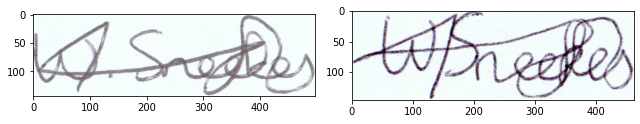

In [ ]:
train_image_path = '/gdrive/My Drive/siamese_signature/data/train_images/'
test_image_path = '/gdrive/My Drive/siamese_signature/data/test_images/'
idx = 95

plot_image(Image.open(train_image_path+train_df['left'][idx]), Image.open(train_image_path+train_df['right'][idx]))
print(train_df['dup'][idx])

**Step 2: Prepare Training Data (in batches)**

In [ ]:
# pre-process images
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import numpy as np
from tqdm import tqdm
IMG_WIDTH = 100
IMG_HEIGHT = 100

def process_image(img_path_list):
  images = []
  for file_name in tqdm(img_path_list):
    #print(train_image_path+left_train_image_path)
    img = image.load_img(train_image_path+file_name, target_size=(IMG_WIDTH,IMG_HEIGHT,1), color_mode="grayscale")
    img = image.img_to_array(img)
    # img = img/255.
    images.append(img)
  return images


In [ ]:
# select only image pairs that are duplicate
dup_idx = (train_df['dup']==0).to_numpy()
dup_idx = [i for i, x in enumerate(dup_idx) if  x]
print("Number of duplicate images", len(dup_idx))
print("Indices of first 10 similar signatures: ", dup_idx[:10])

Number of duplicate images 12602
Indices of first 10 similar signatures:  [96, 97, 98, 99, 100, 101, 102, 103, 104, 105]


In [ ]:
left_train_image_path = np.array(train_df['left'][dup_idx])
right_train_image_path = np.array(train_df['right'][dup_idx])

left_train_images = process_image(left_train_image_path)
right_train_images = process_image(right_train_image_path)


100%|██████████| 12602/12602 [00:53<00:00, 235.80it/s]


In [ ]:
x_left_train, x_left_valid, x_right_train, x_right_valid = train_test_split(left_train_images, right_train_images, random_state=42, test_size=0.2)


In [ ]:
print(len(x_left_train))
print(len(x_left_valid))

print(len(x_right_train))
print(len(x_right_valid))

10081
2521
10081
2521


In [ ]:
import random as rnd
def data_generator(image1, image2, batch_size, shuffle=True):
    """Generator function that yields batches of data

    Args:
        image1 (list): List of transformed (to tensor) images.
        image2 (list): List of transformed (to tensor) images.
        batch_size (int): Number of elements per batch.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [img1a, img2a, img3a, ...] i.e. (img1a,img1b) are duplicates
              input2: targets to your model [img1b, img2b,img3b, ...] i.e. (img1a,img2i) i!=a are not duplicates
    """

    input1 = []
    input2 = []

    idx = 0
    len_q = len(image1)
    image_indexes = [*range(len_q)]
    
    if shuffle:
        rnd.shuffle(image_indexes)
    
    while True:
        if idx >= len_q:
            # if idx is greater than or equal to len_q, set idx accordingly 
            idx = 0
            # shuffle to get random batches if shuffle is set to True
            if shuffle:
                rnd.shuffle(image_indexes)
        
        # get images at the `images_indexes[idx]` position in image1 and image2
        img1 = image1[image_indexes[idx]]
        img2 = image2[image_indexes[idx]]
        
        # increment idx by 1
        idx += 1
        # append q1
        input1.append(img1)
        # append q2
        input2.append(img2)
        if len(input1) == batch_size:
            b1 = []
            b2 = []
            for i1, i2 in zip(input1, input2):
                # append left image
                b1.append(i1)
                # append right image
                b2.append(i2)
            # use b1 and b2
            yield ([np.array(b1), np.array(b2)])   
            # reset the batches
            input1, input2 = [], []

In [ ]:
# TEST - Generate the batch of data
b1,b2 = next(data_generator(x_left_train, x_right_train, 8))
#print("Left Image Batch: ", b1)
#print("Left Image Batch: ", b2)
print(b1.shape)
print(b2.shape)


(8, 100, 100, 1)
(8, 100, 100, 1)


**Step 3: Build Siamese Model (in Trax)**

In [ ]:
def Siamese(input_shape=(IMG_WIDTH, IMG_HEIGHT), embedding_dim=128, mode='train'):
    """Returns a Siamese model.

    Args:
        input_shape (int, int): Shape of Input Image.
        embedding_dim (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        trax.layers.combinators.Parallel: A Siamese model. 
    """

    def normalize(x):  # normalizes the vectors to have L2 norm 1
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    img_processor = tl.Serial(
        tl.Conv(16, (3, 3), padding='VALID'),
        tl.MaxPool(pool_size=(3, 3), padding='VALID'),
        tl.Conv(32, (3, 3), padding='VALID'),
        tl.MaxPool(pool_size=(3, 3), padding='VALID'),
        tl.Fn('Flatten', lambda x: fastnp.reshape(x, (x.shape[0], np.prod(x.shape[1:])))),
        tl.Dense(embedding_dim*2),
        tl.Relu(),
        tl.Dense(embedding_dim*3),
        tl.Relu(),
        tl.Dense(embedding_dim),
        tl.Fn('Normalize', lambda x: normalize(x)),
    )
    
    # Run on Q1 and Q2 in parallel.
    model = tl.Parallel(img_processor, img_processor)
    return model, img_processor


In [ ]:
mmodel, image_encoder = Siamese()
print(model)

Parallel_in2_out2[
  Serial[
    Conv
    MaxPool(3,3)
    Conv
    MaxPool(3,3)
    Flatten
    Dense_256
    Serial[
      Relu
    ]
    Dense_384
    Serial[
      Relu
    ]
    Dense_128
    Normalize
  ]
  Serial[
    Conv
    MaxPool(3,3)
    Conv
    MaxPool(3,3)
    Flatten
    Dense_256
    Serial[
      Relu
    ]
    Dense_384
    Serial[
      Relu
    ]
    Dense_128
    Normalize
  ]
]


Custom Triplet Loss Function (Hard Negative Mining)

In [ ]:
def TripletLossFn(v1, v2, margin=0.25):
    """Custom Loss function, where the magic happens
    Args:
        v1 (numpy.ndarray): Array with dimension (batch_size, d_model)
        v2 (numpy.ndarray): Array with dimension (batch_size, d_model)
        margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
        jax.interpreters.xla.DeviceArray: Triplet Loss.
    """

    scores = fastnp.dot(v1, v2.T)
    batch_size = len(scores)
    positive = fastnp.diagonal(scores)
    # extract negative scores from each row without the diagnoal positive score
    negative_without_positive = scores - (fastnp.eye(batch_size) * 2.0)
    # extract the maximum among negative scores
    # closest_negative = negative_without_positive.max(axis=1)
    closest_negative = fastnp.max(negative_without_positive, axis=1)
    # take the mean of all negatives on each row
    negative_zero_on_duplicate = fastnp.multiply(scores, 1.0 - fastnp.eye(batch_size))
    mean_negative = fastnp.sum(negative_zero_on_duplicate, axis=1) / (batch_size - 1)
    # loss with closest negative
    triplet_loss1 = fastnp.maximum(0.0, margin + closest_negative - positive)
    # loss with mean negative (supposedly minimize the noise)
    triplet_loss2 = fastnp.maximum(0.0, margin + mean_negative - positive)
    # combine two losses
    triplet_loss = fastnp.mean(triplet_loss1 + triplet_loss2)

    return triplet_loss

# create triplet loss function as a Trax layer, later used in the training
from functools import partial
def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)




**Step 4: Model Training**

In [ ]:
batch_size = 32
train_generator = data_generator(x_left_train, x_right_train, batch_size)
val_generator = data_generator(x_left_valid, x_right_valid, batch_size)
b1, b2 = next(val_generator)
b1.shape



(32, 100, 100, 1)

In [ ]:
lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)

# utility function to calculate the accuracy
def accuracy(v1, v2):
    scores = fastnp.dot(v1, v2.T)
    m = fastnp.argmax(scores, axis=-1)
    i = fastnp.arange(len(m))
    mark_list = fastnp.where(i == m, 1, 0)
    mark = fastnp.sum(mark_list)
    return mark / len(mark_list)

def train_model(model, TripletLoss, lr_schedule, train_generator, val_generator, train_steps, output_dir='model/'):
    """Training the Siamese Model

    Args:
        Siamese (function): Function that returns the Siamese model.
        TripletLoss (function): Function that defines the TripletLoss loss function.
        lr_schedule (function): Trax multifactor schedule function.
        train_generator (generator, optional): Training generator. Defaults to train_generator.
        val_generator (generator, optional): Validation generator. Defaults to val_generator.
        output_dir (str, optional): Path to save model to. Defaults to 'model/'.

    Returns:
        trax.supervised.training.Loop: Training loop for the model.
    """
    output_dir = os.path.expanduser(output_dir)

    train_task = training.TrainTask(
        labeled_data=train_generator,
        loss_layer=TripletLoss(),
        optimizer=trax.optimizers.Adam(0.01),
        lr_schedule=lr_schedule,
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator,
        metrics=[TripletLoss(), tl.Fn('Accuracy', accuracy)],
        metric_names = ["Eval Loss", "Eval Acc"],
    )
    

    training_loop = training.Loop(model,
                                  train_task,
                                  eval_tasks=[eval_task],
                                  output_dir=output_dir,
                                  #checkpoint_at=lambda n: n == train_steps
                                  )

    return training_loop

In [ ]:
trax.fastmath.set_backend("tensorflow-numpy")
train_steps = 1500
training_loop = train_model(model, TripletLoss, lr_schedule, train_generator, val_generator, train_steps)
training_loop.run(train_steps)


Step      1: Total number of trainable weights: 69490112
Step      1: Ran 1 train steps in 52.54 secs
Step      1: train TripletLoss |  0.49827889
Step      1: eval    Eval Loss |  0.49928219
Step      1: eval     Eval Acc |  0.25000000

Step    100: Ran 99 train steps in 70.96 secs
Step    100: train TripletLoss |  0.30617950
Step    100: eval    Eval Loss |  0.19724886
Step    100: eval     Eval Acc |  0.68750000

Step    200: Ran 100 train steps in 71.20 secs
Step    200: train TripletLoss |  0.20344559
Step    200: eval    Eval Loss |  0.19981000
Step    200: eval     Eval Acc |  0.71875000

Step    300: Ran 100 train steps in 68.76 secs
Step    300: train TripletLoss |  0.18048002
Step    300: eval    Eval Loss |  0.10336056
Step    300: eval     Eval Acc |  0.75000000

Step    400: Ran 100 train steps in 69.68 secs
Step    400: train TripletLoss |  0.15674750
Step    400: eval    Eval Loss |  0.16430267
Step    400: eval     Eval Acc |  0.68750000

Step    500: Ran 100 train ste

**Step 5: Inference**

In [ ]:
# load saved model
# model = Siamese()
# model.init_from_file('model/model.pkl.gz')
# model.init_from_file('/gdrive/My Drive/siamese_signature/model/model_2/model/model.pkl.gz')

In [ ]:
!dir

In [ ]:
!zip -r signature_model.zip model

In [ ]:
!cp 'signature_model.zip' '/gdrive/My Drive/signature_data/'

In [ ]:
# utility function to predict the similarity between two signatures
def predict(image1, image2, threshold, model, data_generator=data_generator, verbose=False):
    """Function for predicting if two questions are duplicates.

    Args:
        image1 (str): First image.
        image2 (str): Second image.
        threshold (float): Desired threshold.
        model (trax.layers.combinators.Parallel): The Siamese model.
        data_generator (function): Data generator function. Defaults to data_generator.
        verbose (bool, optional): If the results should be printed out. Defaults to False.

    Returns:
        bool: True if the questions are duplicates, False otherwise.
    """
    image1 = process_image([image1])
    image2 = process_image([image2])
    # print(image1[0].shape)
    # pass image1 and image2 arguments of the data generator. Set batch size as 1
    img1, img2 = next(data_generator(image1, image2, batch_size=1))
    print(img1.shape)
    # Call the model
    v1, v2 = model((img1, img2))
    # take dot product to compute cos similarity of each pair of entries, v1, v2
    d = np.dot(v1[0], np.transpose(v2[0]))#.T)
    # d = np.dot(v1[0], v2[0].T)
    # is d greater than the threshold?
    res = d > threshold
    
    ### END CODE HERE ###
    
    if(verbose):
        # print("Image 1  = ", image1, "\nImage 2  = ", image2)
        print("d   = ", d)
        print("res = ", res)

    return res

Testing the prediction with different image pairs

1


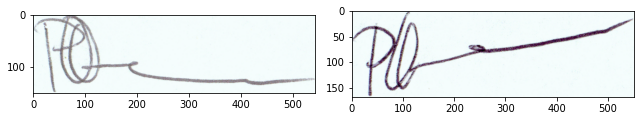

In [ ]:
idx = 2987 #3340 #4361 #5678# 890
plot_image(Image.open(test_image_path+test_df['left'][idx]), Image.open(test_image_path+test_df['right'][idx]))
print(test_df['dup'][idx])

In [ ]:
predict(test_df['left'][idx], test_df['right'][idx], 0.75, model, data_generator, verbose=True)

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

(1, 100, 100, 1)
d   =  0.86664987
res =  True


True

1


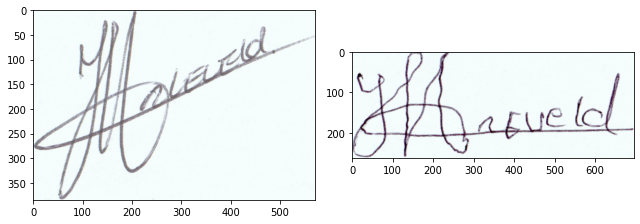

In [ ]:
idx = 890 #90
plot_image(Image.open(test_image_path+test_df['left'][idx]), Image.open(test_image_path+test_df['right'][idx]))
print(test_df['dup'][idx])

In [ ]:
predict(test_df['left'][idx], test_df['right'][idx], 0.7, model, data_generator, verbose=True)

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

(1, 100, 100, 1)
d   =  -0.15126967
res =  False


False

**Convert Trax model into Keras Model**

In [ ]:
#trax.fastmath.set_backend('tensorflow-numpy')
#print(trax.fastmath.backend_name())
print(image_encoder)
model_ = image_encoder
keras_layer = trax.AsKeras(model)
print(keras_layer)


Serial[
  Conv
  MaxPool(3,3)
  Conv
  MaxPool(3,3)
  Flatten
  Dense_256
  Serial[
    Relu
  ]
  Dense_384
  Serial[
    Relu
  ]
  Dense_128
  Normalize
]


In [ ]:
#predict(test_df['left'][idx], test_df['right'][idx], 0.7, keras_layer, data_generator, verbose=True)

In [ ]:
# convert keras layers into keras model
import tensorflow as tf
inputs = tf.keras.Input(shape=(None, IMG_WIDTH, IMG_WIDTH, 1), dtype='float32')
inputs_ = (None, IMG_WIDTH, IMG_HEIGHT, 1)
hidden = keras_layer((inputs, inputs))
# You can add other Keras layers here operating on hidden.
outputs = hidden
keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)

#print(keras_model)

TypeError: ignored